In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

%matplotlib inline

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [3]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [80]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

## Explore (train_set) AKA (train_loader.dataset)

In [4]:
print(train_set)             #trainset[IMAGEINDEX][0-image_tensor,1-class] [CHANNEL][HEIGHT][WIDTH]
print(train_set.data.shape)  #trainset.data[IMAGE INDEX][HEIGHT][WIDTH]

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
torch.Size([60000, 28, 28])


### Single image instance from (train_set)

In [5]:
image , label = next(iter(train_set))   # SAME AS train_set[0] - train_set IS INDEXABLE
print(image.shape)

torch.Size([1, 28, 28])


CHANELLS: 1   HEIGHT: 28   WIDTH: 28
9


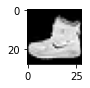

In [6]:
print('CHANELLS: '+str(image.shape[0])+'   HEIGHT: '+str(image.shape[1])+'   WIDTH: '+str(image.shape[2]))
print(label)
plt.figure(figsize = (1,1))
plt.imshow(image.squeeze(), cmap='gray')

### Batch instance from (train_loader)

In [84]:
batch = next(iter(train_loader)) #CANT USE train_loader[0] - NOT INDEXABLE
images , labels = batch          #LOADS 1 BATCH(10 images) AT ONCE
print(images.shape)

torch.Size([10, 1, 28, 28])


tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])


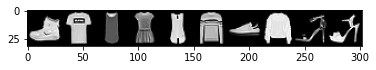

In [85]:
grid = torchvision.utils.make_grid(images, nrow=10)
plt.imshow(np.transpose(grid,(1,2,0)))
print(labels)

The reason for using plt.imshow(np.transpose(grid, (1,2,0)))
For a colored image. plt.imshow takes image dimension in following form [height width channels]. while pytorch follows [channels height width], so for compatibility we have to change pytorch dimensions so that channels appear at end. The standard representation of array is [axis0 axis1 axis2] so we have to convert (0,1,2) to (1,2,0) form to make it compatible for imshow.

## Network & Training

In [17]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        #conv layer 1
        t = F.relu(self.conv1(t))        
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        #conv layer 2
        t = F.relu(self.conv2(t)) 
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        #dense layer 1
        t = F.relu(self.fc1(t.reshape(-1, 12*4*4)))
        
        #dense layer 2
        t = F.relu(self.fc2(t))
        
        #Output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)   #NO NEED BECAUSE LOSSFUNCTION AUTOMATICALL DOES CROSS ENTROPY
        
        return t

In [88]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)

num_epochs = 5

In [89]:
for epoch in range(num_epochs):
    total_loss = 0
    
    for batch in train_loader:
        images, labels = batch
        preds = network(images)
        loss = F.cross_entropy(preds, labels) #calc loss
        
        optimizer.zero_grad()                 #set gradients to zero
        loss.backward()                       #calc gradients
        optimizer.step()
        
        total_loss += loss.item()
    
    print("EPOCH: ",epoch,"   LOSS: ",total_loss)
        

EPOCH:  0    LOSS:  324.9392703175545
EPOCH:  1    LOSS:  229.52297808229923
EPOCH:  2    LOSS:  211.8880841434002
EPOCH:  3    LOSS:  199.13200840353966
EPOCH:  4    LOSS:  192.66468653082848


## Confusion matrix / Analysis

In [90]:
print(len(train_set))
print(train_set.targets)

60000
tensor([9, 0, 0,  ..., 3, 0, 5])


In [91]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [92]:
with torch.no_grad():      #DONT TRACK COMPUTATIONS BECAUSE WE ARENT TRAINING
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

train_preds.shape

torch.Size([60000, 10])

In [93]:
num_correct = get_num_correct(train_preds, train_set.targets)
print(num_correct)

52573


In [94]:
print("ACCURACY: ",num_correct / len(train_set))

ACCURACY:  0.8762166666666666


In [96]:
## FOR CONFUSION MATRIX
matrix = torch.zeros(10,10,dtype = torch.int32)

preds_argmax = train_preds.argmax(dim=1)
print(preds_argmax)
pred_labels = train_set.targets
print(pred_labels)

for i in range(len(preds_argmax)):
    matrix[pred_labels[i],preds_argmax[i]] += 1 #create matrix for every predictioin,label pair increment corresponding box in matrix

tensor([9, 0, 3,  ..., 3, 0, 5])
tensor([9, 0, 0,  ..., 3, 0, 5])


In [97]:
matrix

tensor([[5535,   14,   75,  104,   22,    7,  210,    0,   33,    0],
        [  18, 5860,    3,   87,    8,    2,   16,    0,    6,    0],
        [  95,    4, 4170,   67, 1327,    1,  289,    2,   43,    2],
        [ 241,   56,    7, 5302,  314,    0,   68,    0,   10,    2],
        [  13,    2,  118,  137, 5445,    0,  215,    0,   69,    1],
        [   0,    0,    0,    0,    0, 5709,    0,  251,    5,   35],
        [1443,    5,  468,  110,  802,    2, 3084,    2,   84,    0],
        [   0,    0,    0,    0,    0,   24,    0, 5873,    3,  100],
        [  22,    2,    7,   19,   13,   23,   29,   14, 5869,    2],
        [   0,    0,    0,    0,    0,   29,    0,  243,    2, 5726]],
       dtype=torch.int32)

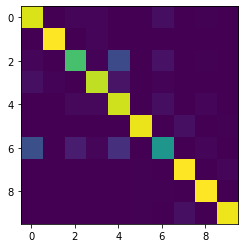

In [98]:
plt.imshow(matrix)